### Shrimp Instance Segmentation & Counting
This notebook implements an end-to-end pipeline for segmenting and counting shrimp using instance segmentation.
**Model Used:** YOLOv8-seg

**Tasks Covered:**
- Merging LabelMe annotations into unified shrimp masks
- Converting to COCO format
- Data splitting (Train/Val/Test)
- Augmentation
- Training
- Inference & shrimp counting

####  Installing  Required Libraries

In [2]:
!pip install labelme
!pip install ultralytics
!pip install opencv-python matplotlib
!pip install shapely

#### Importing Libraries

In [48]:
import os
import json
import random
import cv2
import shutil
import uuid
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from shapely.geometry import Polygon, MultiPolygon
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
dataset= "C:/Yolov8/dataset"
output_dir = "C:/Yolov8/shrimp_coco"
os.makedirs(output_dir + "/images", exist_ok=True)
os.makedirs(output_dir + "/annotations", exist_ok=True)

#### Converting LabelMe JSON to COCO Format with Merged Polygons

In [8]:
coco_output = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 0, "name": "shrimp"}]
}

In [13]:
annotation_id = 0
# Get all JSON files in the dataset folder
json_files = [f for f in os.listdir(dataset) if f.endswith(".json")]

for img_id, json_file in enumerate(tqdm(sorted(json_files))):
    json_path = os.path.join(dataset, json_file)
    with open(json_path) as f:
        data = json.load(f)

    image_filename = data['imagePath']
    image_path = os.path.join(dataset, image_filename)

    # Check if image file exists
    if not os.path.exists(image_path):
        print(f"Warning: Image file '{image_filename}' not found for JSON '{json_file}'. Skipping.")
        continue

    image = np.array(Image.open(image_path))
    height, width = image.shape[:2]
    image_id = img_id

    coco_output["images"].append({
        "id": image_id,
        "width": width,
        "height": height,
        "file_name": image_filename
    })

    # Group all shapes by shrimp instance ID
    instance_groups = {}
    for shape in data["shapes"]:
        label = shape["label"]
        group_id = shape.get("group_id") or str(uuid.uuid4())

        if group_id not in instance_groups:
            instance_groups[group_id] = []
        instance_groups[group_id].append(shape["points"])

    for group_id, polygons in instance_groups.items():
        merged_poly = None
        for pts in polygons:
            poly = Polygon(pts)
            if merged_poly is None:
                merged_poly = poly
            else:
                merged_poly = merged_poly.union(poly)

        if not merged_poly.is_valid:
            continue

        segmentation = []
        if isinstance(merged_poly, MultiPolygon):
            for p in merged_poly.geoms:
                segmentation.append(np.array(p.exterior.coords).ravel().tolist())
        else:
            segmentation.append(np.array(merged_poly.exterior.coords).ravel().tolist())

        bbox = merged_poly.bounds
        x_min, y_min, x_max, y_max = bbox
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        area = merged_poly.area

        coco_output["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": 0,
            "segmentation": segmentation,
            "bbox": [x_min, y_min, bbox_width, bbox_height],
            "area": area,
            "iscrowd": 0
        })
        annotation_id += 1


# Save COCO JSON
with open(f"{output_dir}/annotations/instances_all.json", "w") as f:
    json.dump(coco_output, f)

print("✅ Successfully converted LabelMe to COCO format and merged masks.")

 50%|███████████████████████████████████████▋                                        | 161/325 [00:24<00:07, 23.15it/s]

 51%|████████████████████████████████████████▌                                       | 165/325 [00:24<00:06, 25.35it/s]

 53%|██████████████████████████████████████████▎                                     | 172/325 [00:25<00:05, 28.10it/s]

 55%|███████████████████████████████████████████▊                                    | 178/325 [00:25<00:05, 27.28it/s]

 57%|█████████████████████████████████████████████▌                                  | 185/325 [00:25<00:04, 28.18it/s]

 59%|███████████████████████████████████████████████▌                                | 193/325 [00:25<00:04, 31.21it/s]

 61%|████████████████████████████████████████████████▍                               | 197/325 [00:26<00:04, 31.85it/s]

 63%|██████████████████████████████████████████████████▍                             | 205/325 [00:26<00:03, 31.06it/s]

 65%|████████████████████████████████████████████████████▏                           | 212/325 [00:26<00:03, 29.58it/s]

 67%|█████████████████████████████████████████████████████▉                          | 219/325 [00:26<00:03, 32.02it/s]

 70%|███████████████████████████████████████████████████████▉                        | 227/325 [00:26<00:03, 31.37it/s]

 72%|█████████████████████████████████████████████████████████▌                      | 234/325 [00:27<00:03, 28.79it/s]

 74%|███████████████████████████████████████████████████████████▎                    | 241/325 [00:27<00:02, 31.40it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 250/325 [00:27<00:02, 34.30it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 259/325 [00:27<00:01, 37.56it/s]

 82%|█████████████████████████████████████████████████████████████████▋              | 267/325 [00:28<00:01, 38.16it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 271/325 [00:28<00:01, 37.28it/s]

 86%|████████████████████████████████████████████████████████████████████▉           | 280/325 [00:28<00:01, 37.81it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 288/325 [00:28<00:01, 36.16it/s]

 91%|████████████████████████████████████████████████████████████████████████▊       | 296/325 [00:28<00:00, 35.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████▎    | 306/325 [00:29<00:00, 38.95it/s]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 311/325 [00:29<00:00, 39.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [00:34<00:00,  9.52it/s]


✅ Successfully converted LabelMe to COCO format and merged masks.


#### Preparing  YOLOv8 Dataset Structure

In [15]:
# Paths
coco_json = "C:/Yolov8/shrimp_coco/annotations/instances_all.json"
image_dir = "C:/Yolov8/dataset"
output_dir = "C:/Yolov8/shrimp_coco"

In [16]:
# Creating directory structure
for split in ["train", "val", "test"]:
    os.makedirs(f"{output_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/{split}", exist_ok=True)

In [17]:
# Loading COCO JSON
with open(coco_json) as f:
    coco_data = json.load(f)

images = coco_data['images']
annotations = coco_data['annotations']

In [18]:
# Building image ID → file_name mapping
img_id_to_file = {img["id"]: img["file_name"] for img in images}

In [19]:
# Spliting dataset
train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)

In [20]:
# Creating split folders
split_dict = {
    "train": train_imgs,
    "val": val_imgs,
    "test": test_imgs
}

In [21]:
# Building image_id → annotations map
from collections import defaultdict
img_to_annots = defaultdict(list)
for ann in annotations:
    img_to_annots[ann["image_id"]].append(ann)

#### Converting COCO segmentation to YOLOv8 segmentation format

In [23]:
def coco_poly_to_yolo(poly, img_width, img_height):
    norm_coords = []
    for i in range(0, len(poly), 2):
        x = poly[i] / img_width
        y = poly[i+1] / img_height
        norm_coords.append(x)
        norm_coords.append(y)
    return norm_coords

for split, imgs in split_dict.items():
    for img in tqdm(imgs, desc=f"Processing {split}"):
        fname = img["file_name"]
        shutil.copy(os.path.join(image_dir, fname), os.path.join(output_dir, "images", split, fname))

        img_id = img["id"]
        width, height = img["width"], img["height"]
        anns = img_to_annots[img_id]

        label_txt = ""
        for ann in anns:
            for seg in ann["segmentation"]:
                seg = coco_poly_to_yolo(seg, width, height)
                coords = " ".join([f"{x:.6f}" for x in seg])
                label_txt += f"0 {coords}\n"  # class 0 = shrimp

        with open(os.path.join(output_dir, "labels", split, fname.replace(".jpg", ".txt")), "w") as f:
            f.write(label_txt)
            
print("✅ Annotations converted to YOLO segmentation format.")

Processing test: 100%|████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 223.82it/s]

✅ Annotations converted to YOLO segmentation format.


#### YAML Configuration for Training

In [24]:
dataset_yaml = """\
path: "C:/Yolov8/shrimp_coco"
train: "C:/Yolov8/shrimp_coco/images/train"
val: "C:/Yolov8/shrimp_coco/images/val"
test: "C:/Yolov8/shrimp_coco/images/test"

names:
  0: shrimp
"""

with open("C:/Yolov8/shrimp_coco/dataset.yaml", "w") as f:
    f.write(dataset_yaml)
    
print("✅ YOLOv8 config file created.")

✅ YOLOv8 config file created.


#### Training the YOLOv8-seg Model

In [26]:
# Loading YOLOv8-seg model (pretrained)
model = YOLO("yolov8n-seg.pt")

In [28]:
# Train the model
model.train(
    data="yolo_data/dataset.yaml",
    epochs=10,
    imgsz=640,
    batch=8,
    name="shrimp_seg_model",
    augment=True,
    workers=2,
    verbose=True
)

Ultralytics 8.3.107  Python-3.11.4 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=yolo_data/dataset.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=2, project=None, name=shrimp_seg_model2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning C:\Yolov8\shrimp_coco\labels\train... 132 images, 0 backgrounds, 56 corrupt: 100%|██████████| 132/132 [

train: WARNING  C:\Yolov8\shrimp_coco\images\train\IMG_0013.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1804      1.2431      1.1328]
train: WARNING  C:\Yolov8\shrimp_coco\images\train\IMG_0043.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0922      1.2077      1.0031]
train: WARNING  C:\Yolov8\shrimp_coco\images\train\IMG_0045.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4487       1.514      1.3915]
train: WARNING  C:\Yolov8\shrimp_coco\images\train\IMG_0052.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1671      1.3447]
train: WARNING  C:\Yolov8\shrimp_coco\images\train\IMG_0061.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0582]
train: WARNING  C:\Yolov8\shrimp_coco\images\train\IMG_0077.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0935


val: Scanning C:\Yolov8\shrimp_coco\labels\val... 17 images, 0 backgrounds, 1 corrupt: 100%|██████████| 17/17 [00:00<00

val: WARNING  C:\Yolov8\shrimp_coco\images\val\IMG_0118.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.106      1.1432      1.2625]
val: New cache created: C:\Yolov8\shrimp_coco\labels\val.cache


Plotting labels to runs\segment\shrimp_seg_model2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\segment\shrimp_seg_model2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      2.724      5.009      4.029      2.438         10        640: 100%|██████████| 10/10 [02:05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65     0.0025      0.185     0.0457      0.031   0.000833     0.0615   0.000589   0.000126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.676      4.418      3.585      2.192         11        640: 100%|██████████| 10/10 [01:56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65    0.00375      0.277     0.0475     0.0234    0.00167      0.123       0.02      0.003



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G       2.69      4.183      3.481      2.194         29        640: 100%|██████████| 10/10 [01:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65    0.00375      0.277     0.0564      0.029    0.00125     0.0923     0.0167    0.00257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.536      4.001      3.196      2.085         15        640: 100%|██████████| 10/10 [01:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65       0.43     0.0308     0.0503     0.0357      0.253     0.0154      0.018    0.00536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      2.552      3.832      3.154      2.051         25        640: 100%|██████████| 10/10 [01:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65    0.00375      0.277     0.0361    0.00938   0.000833     0.0615     0.0255      0.006



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      2.487      3.774      3.176      2.009         22        640: 100%|██████████| 10/10 [01:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65      0.654     0.0308     0.0456     0.0266    0.00125     0.0923    0.00105   0.000287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      2.537      3.786      3.167      2.092         13        640: 100%|██████████| 10/10 [01:49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65      0.527     0.0308     0.0579     0.0375      0.527     0.0308       0.03    0.00481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      2.404      3.723      3.003      1.994         14        640: 100%|██████████| 10/10 [01:53
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65      0.298     0.0615     0.0633      0.042       0.16     0.0308     0.0423    0.00977



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      2.489       3.77       3.06      1.972         13        640: 100%|██████████| 10/10 [01:52
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65      0.293      0.083     0.0751     0.0441      0.288     0.0769     0.0619     0.0161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      2.347      3.845      2.916       1.92         15        640: 100%|██████████| 10/10 [01:44
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         16         65      0.412     0.0923      0.124     0.0736       0.46     0.0923     0.0972     0.0271



10 epochs completed in 0.361 hours.
Optimizer stripped from runs\segment\shrimp_seg_model2\weights\last.pt, 6.8MB
Optimizer stripped from runs\segment\shrimp_seg_model2\weights\best.pt, 6.8MB

Validating runs\segment\shrimp_seg_model2\weights\best.pt...
Ultralytics 8.3.107  Python-3.11.4 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WA

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all         16         65      0.423     0.0923      0.124     0.0737      0.456     0.0923     0.0974     0.0272
Speed: 5.1ms preprocess, 373.9ms inference, 0.0ms loss, 45.1ms postprocess per image
Results saved to runs\segment\shrimp_seg_model2


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F880E6ED90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0410

In [29]:
# Evaluating model on the test set
metrics = model.val(split='test')

Ultralytics 8.3.107  Python-3.11.4 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning C:\Yolov8\shrimp_coco\labels\test... 17 images, 0 backgrounds, 9 corrupt: 100%|██████████| 17/17 [00:00<0


val: WARNING  C:\Yolov8\shrimp_coco\images\test\IMG_0081.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1351      1.1307      1.1414]
val: WARNING  C:\Yolov8\shrimp_coco\images\test\IMG_0084.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.099       1.093]
val: WARNING  C:\Yolov8\shrimp_coco\images\test\IMG_0097.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2376      1.1153      1.2807]
val: WARNING  C:\Yolov8\shrimp_coco\images\test\IMG_0104.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.4839      1.1552      1.0051      1.3441      1.2388      1.0125]
val: WARNING  C:\Yolov8\shrimp_coco\images\test\IMG_0107.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     5.3275      2.6736      6.6072      4.9846       3.745      4.0521      1.1635      1.1352      6.1051      2.7803      1.5071]
val: WARNI

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

WARNING  Model does not support 'augment=True', reverting to single-scale prediction.
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...
WARNING  Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all          8         32      0.579      0.188       0.18      0.119      0.569      0.156      0.148     0.0444
Speed: 7.2ms preprocess, 380.1ms inference, 0.0ms loss, 40.7ms postprocess per image
Results saved to runs\segment\shrimp_seg_model22


#### Runing Inference on Test Images

In [32]:
# Loading your trained model (from the previous training step)
model = YOLO('runs/segment/shrimp_seg_model2/weights/best.pt')

In [34]:
# Defining test image directory
test_image_dir = "C:/Yolov8/shrimp_coco/images/test"
test_images = [os.path.join(test_image_dir, img) for img in os.listdir(test_image_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]

In [41]:
# Creating directory for inference outputs
output_dir = 'C:/Yolov8/shrimp_coco/inference_output'
os.makedirs(output_dir, exist_ok=True)

In [42]:
# Runing prediction on all test images
results = model.predict(source=test_images, save=True, save_txt=False, save_conf=True, project=output_dir, name='preds')


0: 640x640 1 shrimp, 345.4ms
1: 640x640 (no detections), 345.4ms
2: 640x640 1 shrimp, 345.4ms
3: 640x640 1 shrimp, 345.4ms
4: 640x640 (no detections), 345.4ms
5: 640x640 (no detections), 345.4ms
6: 640x640 (no detections), 345.4ms
7: 640x640 (no detections), 345.4ms
8: 640x640 (no detections), 345.4ms
9: 640x640 (no detections), 345.4ms
10: 640x640 (no detections), 345.4ms
11: 640x640 (no detections), 345.4ms
12: 640x640 (no detections), 345.4ms
13: 640x640 (no detections), 345.4ms
14: 640x640 1 shrimp, 345.4ms
15: 640x640 (no detections), 345.4ms
16: 640x640 (no detections), 345.4ms
Speed: 8.9ms preprocess, 345.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Yolov8\shrimp_coco\inference_output\preds


#### Visualize + Counting Shrimp in Each Image

In [43]:
import pandas as pd

shrimp_counts = []

for r in results:
    image_name = os.path.basename(r.path)
    num_instances = len(r.masks) if r.masks else 0
    shrimp_counts.append({"image_name": image_name, "shrimp_count": num_instances})

df_counts = pd.DataFrame(shrimp_counts)

In [44]:
csv_path = os.path.join(output_dir, "shrimp_counts.csv")
df_counts.to_csv(csv_path, index=False)
print(f"✅ Shrimp counts saved to: {csv_path}")

✅ Shrimp counts saved to: C:/Yolov8/shrimp_coco/inference_output\shrimp_counts.csv


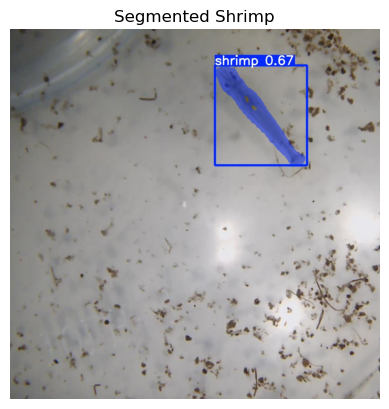

In [49]:
output = "C:/Yolov8/shrimp_coco/inference_output/preds"
sample_image = cv2.imread(os.path.join(output, 'IMG_0023.jpg'))
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Shrimp")
plt.axis('off')
plt.show()